# This notebook demonstrates ploting MCS tracks on Tb, precipitation snapshots for a subset domain
## It is the same with the following Python script that makes plots in parallel, but allows visually tweaking the plots.
* /Analysis/plot_subset_tbpf_mcs_tracks_demo.py

In [1]:
import argparse
import numpy as np
import os
import xarray as xr
import pandas as pd
from scipy.ndimage import binary_erosion
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import colorcet as cc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# For non-gui matplotlib back end
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# mpl.use('agg')
# import dask
# from dask.distributed import Client, LocalCluster
import warnings
warnings.filterwarnings("ignore")
from pyflextrkr.ft_utilities import load_config, subset_files_timerange
%matplotlib inline

In [2]:
# Specify time period to plot
start_datetime = '2020-02-01T00'
end_datetime = '2020-02-02T00'
# Tracking config file
config_file = '/global/homes/f/feng045/program/PyFLEXTRKR/config/config_dyamond_obs.yml'
# Orientation of 2-panel plot
panel_orientation = 'horizontal'
# Subset map extent (lonmin, lonmax, latmin, latmax)
map_extent = [150, 210, -30, 15]
# Figure size (inches), also determines figure aspect ratio
figsize = [10, 10]

# figsize = [10, 8]
# map_extent = [85, 175, -25, 15]

lonv = np.arange(-180, 360.01, 30)
latv = np.arange(-90, 90.01, 10)
    
# Figure output directory
figdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/quicklooks_trackpaths/obs/'
os.makedirs(figdir, exist_ok=True)
print(f'Fig dir: {figdir}')

Fig dir: /global/cfs/cdirs/m1867/zfeng/dyamond-winter/quicklooks_trackpaths/obs/


In [3]:
-82.%360, -35.%360

(278.0, 325.0)

## Custom functions to prepare plotting data

In [4]:
#-----------------------------------------------------------------------
def label_perimeter(tracknumber, dilationstructure):
    """
    Labels the perimeter on a 2D map from object tracknumber masks.
    """
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)

    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the cell mask
        itn = tracknumber == ii
        # Erode the cell by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the track number
        tracknumber_perim[iperim == 1] = ii

    return tracknumber_perim

#-----------------------------------------------------------------------
def get_track_stats(trackstats_file, start_datetime, end_datetime, dt_thres):
    """
    Subset tracks statistics data within start/end datetime

    Args:
        trackstats_file: string
            Track statistics file name.
        start_datetime: string
            Start datetime to subset tracks.
        end_datetime: dstring
            End datetime to subset tracks.
        dt_thres: timedelta
            A timedelta threshold to retain tracks.
            
    Returns:
        track_dict: dictionary
            Dictionary containing track stats data.
    """
    # Read track stats file
    dss = xr.open_dataset(trackstats_file)
    stats_starttime = dss['base_time'].isel(times=0)
    # Convert input datetime to np.datetime64
    stime = np.datetime64(start_datetime)
    etime = np.datetime64(end_datetime)
    time_res = dss.attrs['time_resolution_hour']

    # Find tracks initiated within the time window
    idx = np.where((stats_starttime >= stime) & (stats_starttime <= etime))[0]
    ntracks = len(idx)
    print(f'Number of tracks within input period: {ntracks}')

    # Subset these tracks and put in a dictionary    
    track_dict = {
        'ntracks': ntracks,
        'lifetime': dss['track_duration'].isel(tracks=idx) * time_res,
        'track_bt': dss['base_time'].isel(tracks=idx),
        'track_ccs_lon': dss['meanlon'].isel(tracks=idx),
        'track_ccs_lat': dss['meanlat'].isel(tracks=idx),
        'track_pf_lon': dss['pf_lon_centroid'].isel(tracks=idx, nmaxpf=0),
        'track_pf_lat': dss['pf_lat_centroid'].isel(tracks=idx, nmaxpf=0),
        'track_pf_diam': 2 * np.sqrt(dss['pf_area'].isel(tracks=idx, nmaxpf=0) / np.pi),
        'dt_thres': dt_thres,
        'time_res': time_res,
    }
    
    return track_dict

#-----------------------------------------------------------------------
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ 
    Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Plotting fuction

In [5]:
#-----------------------------------------------------------------------
def plot_map_2panels(pixel_dict, plot_info, map_info, track_dict):
    """
    Plot 2 rows with Tb, Precipitation and MCS tracks snapshot.

    Args:
        pixel_dict: dictionary
            Dictionary containing pixel data variables.
        plot_info: dictionary
            Dictionary containing plotting setup variables.
        map_info: dictionary
            Dictionary containing map boundary info.
        track_dict: dictionary
            Dictionary containing tracking data variables.
            
    Returns:
        fig: object
            Figure handle.
    """
        
    # Get pixel data from dictionary
    lon = pixel_dict['lon']
    lat = pixel_dict['lat']
    tb = pixel_dict['tb']
    pcp = pixel_dict['pcp']
    tracknumber = pixel_dict['tracknumber']
    tn_perim = pixel_dict['tracknumber_perim']
    pixel_bt = pixel_dict['pixel_bt']
    # Get track data from dictionary
    ntracks = track_dict['ntracks']
    lifetime = track_dict['lifetime']
    track_bt = track_dict['track_bt']
    track_ccs_lon = track_dict['track_ccs_lon']
    track_ccs_lat = track_dict['track_ccs_lat']
    track_pf_lon = track_dict['track_pf_lon']
    track_pf_lat = track_dict['track_pf_lat']
    track_pf_diam = track_dict['track_pf_diam']
    dt_thres = track_dict['dt_thres']
    time_res = track_dict['time_res']
    # Get plot info from dictionary
    levels = plot_info['levels']
    cmaps = plot_info['cmaps']
    titles = plot_info['titles'] 
    cblabels = plot_info['cblabels']
    cbticks = plot_info['cbticks']
    timestr = plot_info['timestr']
    figname = plot_info['figname']
    figsize = plot_info['figsize']
    panel_orientation = plot_info['panel_orientation']
    # Map domain, lat/lon ticks, background map features
    map_extent = map_info['map_extent']
    lonv = map_info.get('lonv', None)
    latv = map_info.get('latv', None)
    draw_border = map_info.get('draw_border', False)
            
    # Time difference matching pixel-time and track time
    dt_match = 1  # [min]
    
    # Size, line width for tracks
    size_c = 10
    lw_c = 1.5
    lw_r = 1
    trackpath_color = 'purple'
    mcsperim_color = 'magenta'
    pfdiam_color = 'magenta'
    marker_style = dict(edgecolor='purple', facecolor='purple', linestyle='-', marker='o')
    # cmap_tracks = 'Spectral_r'
    # cblabel_tracks = 'Lifetime (hour)'
    # lev_lifetime = np.arange(5, 25.1, 5)
    # cbticks_tracks = np.arange(5, 25.1, 5)
    # cmap_lifetime = plt.get_cmap(cmap_tracks)
    # norm_lifetime = mpl.colors.BoundaryNorm(lev_lifetime, ncolors=cmap_lifetime.N, clip=True)

    # Set up map projection
    proj = ccrs.PlateCarree(central_longitude=180)
    data_proj = ccrs.PlateCarree(central_longitude=0)
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    # Set up figure
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    fig = plt.figure(figsize=figsize, dpi=300, facecolor='w')
    # vertical: left + right panel
    if panel_orientation == 'vertical':
        gs = gridspec.GridSpec(2,2, height_ratios=[1,0.02], width_ratios=[1,1])
        gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.15, hspace=0.15)
        ax2 = plt.subplot(gs[0,1], projection=proj)        
        cax1 = plt.subplot(gs[1,0])
        cb_orientation = 'horizontal'
    # horizontal: top + bottom panel
    if panel_orientation == 'horizontal':
        gs = gridspec.GridSpec(2,2, height_ratios=[0.4,0.4], width_ratios=[1,0.02])
        gs.update(left=0.05, right=0.93, bottom=0.05, top=0.9, wspace=0.03, hspace=0.2)
        ax2 = plt.subplot(gs[1,0], projection=proj)
        cax1 = plt.subplot(gs[0,1])
        cb_orientation = 'vertical'
    # Figure title: time
    fig.text(0.5, 0.96, timestr, fontsize=14, ha='center')

    #################################################################
    # Tb Panel
    ax1 = plt.subplot(gs[0,0], projection=proj)
    ax1.set_extent(map_extent, crs=data_proj)
    ax1.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    if draw_border == True:
        ax1.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
    ax1.set_aspect('auto', adjustable=None)
    ax1.set_title(titles['tb_title'], loc='left')
    gl = ax1.gridlines(crs=data_proj, draw_labels=True, linestyle='--', linewidth=0.5)
    gl.right_labels = False
    gl.top_labels = False
    if (lonv is not None) & (latv is not None):
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()        
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    cmap = plt.get_cmap(cmaps['tb_cmap'])
    norm = mpl.colors.BoundaryNorm(levels['tb_levels'], ncolors=cmap.N, clip=True)
    tb_masked = np.ma.masked_where((np.isnan(tb)), tb)
    cf1 = ax1.pcolormesh(lon, lat, tb_masked, norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    # Overplot cloudtracknumber boundary
    tn = np.copy(tracknumber.data)
    # Replace all valid cloudtracknumber with a constant, and invalid cloudtracknumber with 0
    tn[(tn >= 1)] = 10
    tn[np.isnan(tn)] = 0
    # Overlay boundary of cloudtracknumber on Tb
    Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
    Tn[Tn > 0] = 10
    tn1 = ax1.pcolormesh(lon, lat, Tn, cmap='cool_r', transform=data_proj, zorder=3)
    # Tb Colorbar
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels['tb_label'], ticks=cbticks['tb_ticks'], extend='both', orientation=cb_orientation)
    
    #################################################################
    # Precipitation Panel
    ax2.set_extent(map_extent, crs=data_proj)
    ax2.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    if draw_border == True:
        ax2.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
    ax2.set_aspect('auto', adjustable=None)
    ax2.set_title(titles['pcp_title'], loc='left')
    gl = ax2.gridlines(crs=data_proj, draw_labels=True, linestyle='--', linewidth=0.5)
    gl.right_labels = False
    gl.top_labels = False
    if (lonv is not None) & (latv is not None):
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)

    # MCS track number mask
    cmap = plt.get_cmap(cmaps['tn_cmap'])
    norm = mpl.colors.BoundaryNorm(levels['tn_levels'], ncolors=cmap.N, clip=True)
    # norm = mpl.colors.BoundaryNorm(levels['tn_levels'], ncolors=cmap.N, clip=False)
    tracknumber_masked = np.ma.masked_invalid(tracknumber)
    cm1 = ax2.pcolormesh(lon, lat, tracknumber_masked, norm=norm, cmap=cmap, transform=data_proj, zorder=2, alpha=0.7)
    
    # Precipitation
    cmap = plt.get_cmap(cmaps['pcp_cmap'])
    norm = mpl.colors.BoundaryNorm(levels['pcp_levels'], ncolors=cmap.N, clip=True)
    pcp_masked = np.ma.masked_where(((pcp < min(levels['pcp_levels']))), pcp)
    cf2 = ax2.pcolormesh(lon, lat, pcp_masked, norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    # Colorbar
    cax2 = plt.subplot(gs[1,1])
    cb2 = plt.colorbar(cf2, cax=cax2, label=cblabels['pcp_label'], ticks=cbticks['pcp_ticks'], extend='both', orientation=cb_orientation)
    
    #################################################################
    # Plot track centroids and paths
    for itrack in range(0, ntracks):
        # Get duration of the track
        ilifetime = lifetime.data[itrack]
        itracknum = lifetime.tracks.data[itrack]+1
        idur = (ilifetime / time_res).astype(int)
        idiam = track_pf_diam.data[itrack,:idur]       
        # Get basetime of the track and the track end time
        ibt = track_bt.data[itrack,:idur]
        ibt_end = np.nanmax(ibt)
        # Compute time difference between current pixel-level data time and the end time of the track
        idt_end = (pixel_bt - ibt_end).astype('timedelta64[h]')
        # Proceed if time difference is <= threshold
        # This means for tracks that end longer than the time threshold are not plotted
        if (idt_end <= dt_thres):
            # Find times in track data <= current pixel-level file time
            idx_cut = np.where(ibt <= pixel_bt)[0]
            idur_cut = len(idx_cut)
            if (idur_cut > 0):
                # Track path
                color_vals = np.repeat(ilifetime, idur_cut)
                size_vals = np.repeat(size_c, idur_cut)
                size_vals[0] = size_c * 2
                cc1 = ax1.plot(track_ccs_lon.data[itrack,idx_cut], track_ccs_lat.data[itrack,idx_cut], lw=lw_c, ls='-', color=trackpath_color, transform=data_proj, zorder=3)
                cc2 = ax2.plot(track_ccs_lon.data[itrack,idx_cut], track_ccs_lat.data[itrack,idx_cut], lw=lw_c, ls='-', color=trackpath_color, transform=data_proj, zorder=3)
                # Initiation location
                cl1 = ax1.scatter(track_ccs_lon.data[itrack,0], track_ccs_lat.data[itrack,0], s=size_c*2, transform=data_proj, zorder=4, **marker_style)
                cl2 = ax2.scatter(track_ccs_lon.data[itrack,0], track_ccs_lat.data[itrack,0], s=size_c*2, transform=data_proj, zorder=4, **marker_style)
                
        # Find the closest time from track times
        idt = np.abs((ibt - pixel_bt).astype('timedelta64[m]'))
        idx_match = np.argmin(idt)
        idt_match = idt[idx_match]
        # Get PF radius from the matched tracks
        _irad = idiam[idx_match] / 2
        _ilon = track_pf_lon.data[itrack,idx_match]
        _ilat = track_pf_lat.data[itrack,idx_match]
        _iccslon = track_ccs_lon.data[itrack,idx_match]
        _iccslat = track_ccs_lat.data[itrack,idx_match]
        # Proceed if time difference is < dt_match
        if (idt_match < dt_match):
            # Plot PF diameter circle
            if ~np.isnan(_irad):
                ipfcircle = ax2.tissot(rad_km=_irad*2, lons=_ilon, lats=_ilat, n_samples=100, facecolor='None', edgecolor=pfdiam_color, lw=lw_r, zorder=3)
            # Overplot tracknumbers at current frame
            if (_iccslon > map_extent[0]) & (_iccslon < map_extent[1]) & (_iccslat > map_extent[2]) & (_iccslat < map_extent[3]):
                ax1.text(_iccslon+0.05, _iccslat+0.05, f'{itracknum:.0f}', color='k', size=8, weight='bold', ha='left', va='center', transform=data_proj, zorder=3)
                ax2.text(_iccslon+0.05, _iccslat+0.05, f'{itracknum:.0f}', color='k', size=8, weight='bold', ha='left', va='center', transform=data_proj, zorder=3)
    
    # Custom legend for track paths
    legend_elements1 = [
        mpl.lines.Line2D([0], [0], color=trackpath_color, marker='o', lw=lw_c, label='MCS Tracks'),
        mpl.lines.Line2D([0], [0], marker='o', lw=0, markerfacecolor='None', markeredgecolor=mcsperim_color, markersize=12, label='MCS Mask'),
    ]
    legend_elements2 = [
        mpl.lines.Line2D([0], [0], color=trackpath_color, marker='o', lw=lw_c, label='MCS Tracks'),
        mpl.lines.Line2D([0], [0], marker='o', lw=0, markerfacecolor='None', markeredgecolor=pfdiam_color, markersize=12, label='PF Diam (x2)'),
    ]
    ax1.legend(handles=legend_elements1, fontsize=10, loc='lower right')
    ax2.legend(handles=legend_elements2, fontsize=10, loc='lower right')
    
    # Thread-safe figure output
    # canvas = FigureCanvas(fig)
    # canvas.print_png(figname)
    fig.savefig(figname)
    
    return fig

## Function to work with a pixel-level file

In [6]:
#-----------------------------------------------------------------------
def work_for_time_loop(datafile, track_dict, map_info, figdir):
    """
    Work with a pixel-level file.

    Args:
        datafile: string
            Pixel-level file name.
        track_dict: dictionary
            Dictionary containing tracking data variables.
        map_info: dictionary
            Dictionary containing map boundary info.
        figdir: string
            Directory name for figures.
            
    Returns:
        1: success.            
    """

    map_extent = map_info.get('map_extent', None)

    # Read pixel-level data
    ds = xr.open_dataset(datafile)
    pixel_bt = ds['time'].data

    # Get map extent from data
    if map_extent is None:
        lonmin = ds['longitude'].min().item()
        lonmax = ds['longitude'].max().item()
        latmin = ds['latitude'].min().item()
        latmax = ds['latitude'].max().item()
        map_extent = [lonmin, lonmax, latmin, latmax]
        map_info['map_extent'] = map_extent
    
    # Make dilation structure (larger values make thicker outlines)
    perim_thick = 6
    dilationstructure = np.zeros((perim_thick+1,perim_thick+1), dtype=int)
    dilationstructure[1:perim_thick, 1:perim_thick] = 1

    # Get tracknumbers
    tn = ds['cloudtracknumber'].squeeze()
    # Only plot if there is track in the frame
    if (np.nanmax(tn) > 0):
        
        # Precipitation color levels
        pcp_levels = [2,3,4,5,6,8,10,15]
        pcp_ticks = pcp_levels
        # Tb color levels
        tb_levels = np.arange(200, 320.1, 10)
        tb_ticks = np.arange(200, 320.1, 20)
        # Tracknumber color levels for MCS masks (limit to 256 to fit in a colormap)
        tracknumbers = track_dict['lifetime'].tracks
        tn_nlev = np.min([len(tracknumbers), 256])
        tn_levels = np.linspace(np.min(tracknumbers)+1, np.max(tracknumbers)+1, tn_nlev)
        levels = {'tb_levels':tb_levels, 'pcp_levels':pcp_levels, 'tn_levels':tn_levels}
        cbticks = {'tb_ticks':tb_ticks, 'pcp_ticks':pcp_ticks}
        cblabels = {'tb_label':'Tb (K)', 'pcp_label':'Precipitation (mm h$^{-1}$)'}
        # Truncate colormaps
        tb_cmap = truncate_colormap(plt.get_cmap('jet'), minval=0.05, maxval=0.95)
        pcp_cmap = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0)
        tn_cmap = cc.cm["glasbey_light"]
        cmaps = {'tb_cmap':tb_cmap, 'pcp_cmap':pcp_cmap, 'tn_cmap':tn_cmap}
        titles = {'tb_title':'(a) IR Brightness Temperature', 'pcp_title':'(b) Precipitation (Tracked MCSs Shaded)'}

        # Subset pixel data within the map domain        
        lonmin, lonmax = map_extent[0], map_extent[1]
        latmin, latmax = map_extent[2], map_extent[3]
        mask = (ds['longitude'] >= lonmin) & (ds['longitude'] <= lonmax) & (ds['latitude'] >= latmin) & (ds['latitude'] <= latmax)
        tb_sub = ds['tb'].where(mask == True, drop=True).squeeze()
        pcp_sub = ds['precipitation'].where(mask == True, drop=True).squeeze()
        tracknumber_sub = ds['cloudtracknumber'].where(mask == True, drop=True).squeeze()
        lon_sub = ds['longitude'].where(mask == True, drop=True)
        lat_sub = ds['latitude'].where(mask == True, drop=True)
        # Get object perimeters
        tn_perim = label_perimeter(tracknumber_sub.data, dilationstructure)

        # Put pixel data in a dictionary
        pixel_dict = {
            'lon': lon_sub, 
            'lat': lat_sub, 
            'tb': tb_sub, 
            'pcp': pcp_sub, 
            'tracknumber': tracknumber_sub, 
            'tracknumber_perim': tn_perim,
            'pixel_bt': pixel_bt,
        }
        fdatetime = pd.to_datetime(ds['time'].data.item()).strftime('%Y%m%d_%H%M')
        timestr = pd.to_datetime(ds['time'].data.item()).strftime('%Y-%m-%d %H:%M UTC')
        figname = f'{figdir}{fdatetime}.png'
        # print(timestr)
        plot_info = {
            'levels': levels, 
            'cmaps': cmaps, 
            'titles': titles, 
            'cblabels': cblabels, 
            'cbticks': cbticks, 
            'timestr': timestr, 
            'figname': figname,
            'figsize': map_info['figsize'],
            'panel_orientation': map_info['panel_orientation'],
        }
        fig = plot_map_2panels(pixel_dict, plot_info, map_info, track_dict)
        # plt.close(fig)
        print(figname)

    ds.close()
    return 1

## Main function to prepare data

In [7]:
# Customize lat/lon labels
lonv = None
latv = None
# Put map info in a dictionary
map_info = {
    'map_extent': map_extent,
    'lonv': lonv,
    'latv': latv,
    'figsize': figsize,
    'panel_orientation': panel_orientation,
    'draw_border': False,
}

# Create a timedelta threshold
# Tracks that end longer than this threshold from the current pixel-level frame are not plotted
# This treshold controls the time window to retain previous tracks
dt_thres = datetime.timedelta(hours=1)

# Track stats file
config = load_config(config_file)
stats_path = config["stats_outpath"]
pixeltracking_path = config["pixeltracking_outpath"]
pixeltracking_filebase = config["pixeltracking_filebase"]
mcsfinal_filebase = config["mcsfinal_filebase"]
startdate = config["startdate"]
enddate = config["enddate"]
trackstats_file = f"{stats_path}{mcsfinal_filebase}{startdate}_{enddate}.nc"
n_workers = config["nprocesses"]

# Convert datetime string to Epoch time (base time)
start_basetime = pd.to_datetime(start_datetime).timestamp()
end_basetime = pd.to_datetime(end_datetime).timestamp()

# Find all pixel-level files that match the input datetime
datafiles, \
datafiles_basetime, \
datafiles_datestring, \
datafiles_timestring = subset_files_timerange(
    pixeltracking_path,
    pixeltracking_filebase,
    start_basetime,
    end_basetime,
    time_format="yyyymodd_hhmm",
)
print(f'Number of pixel files: {len(datafiles)}')

# Get track stats data
track_dict = get_track_stats(trackstats_file, start_datetime, end_datetime, dt_thres)

Number of pixel files: 24
Number of tracks within input period: 88


## Loop over the data files to plot individual frames

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs//mcstracking/20200120.0000_20200301.0000/mcstrack_20200201_2030.nc
/global/cfs/cdirs/m1867/zfeng/dyamond-winter/quicklooks_trackpaths/obs/20200201_2030.png
/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs//mcstracking/20200120.0000_20200301.0000/mcstrack_20200201_2130.nc
/global/cfs/cdirs/m1867/zfeng/dyamond-winter/quicklooks_trackpaths/obs/20200201_2130.png


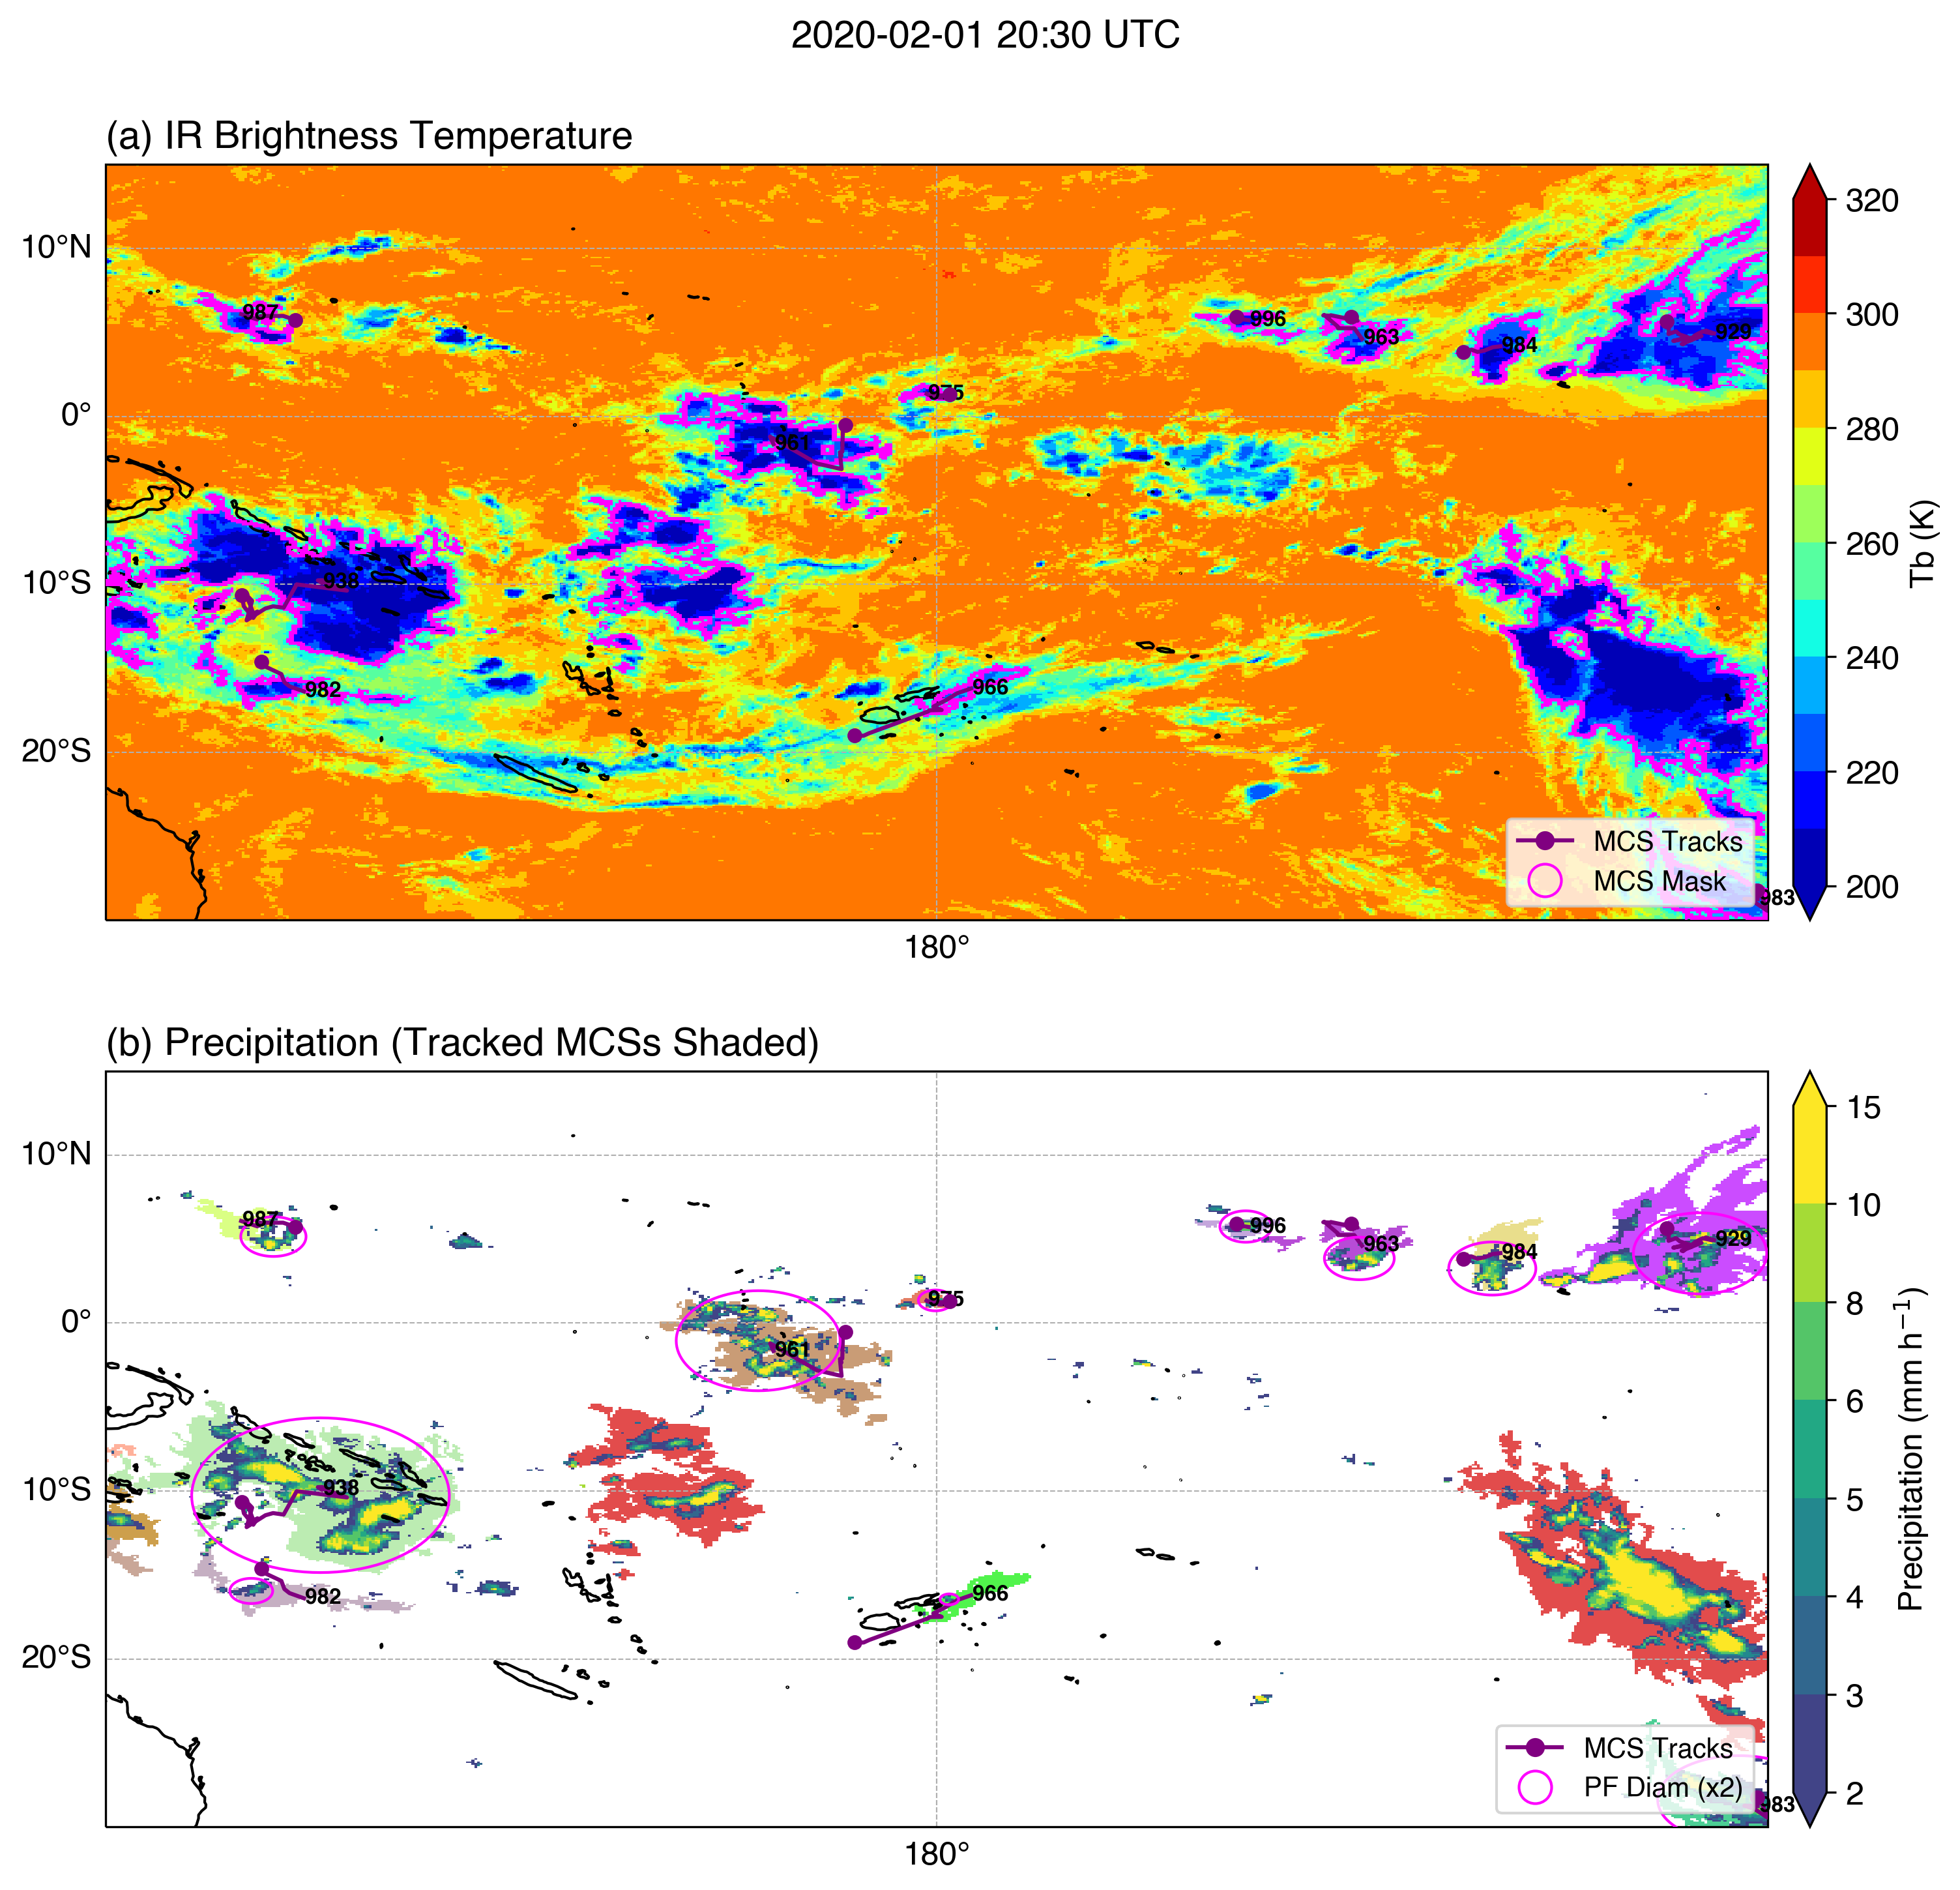

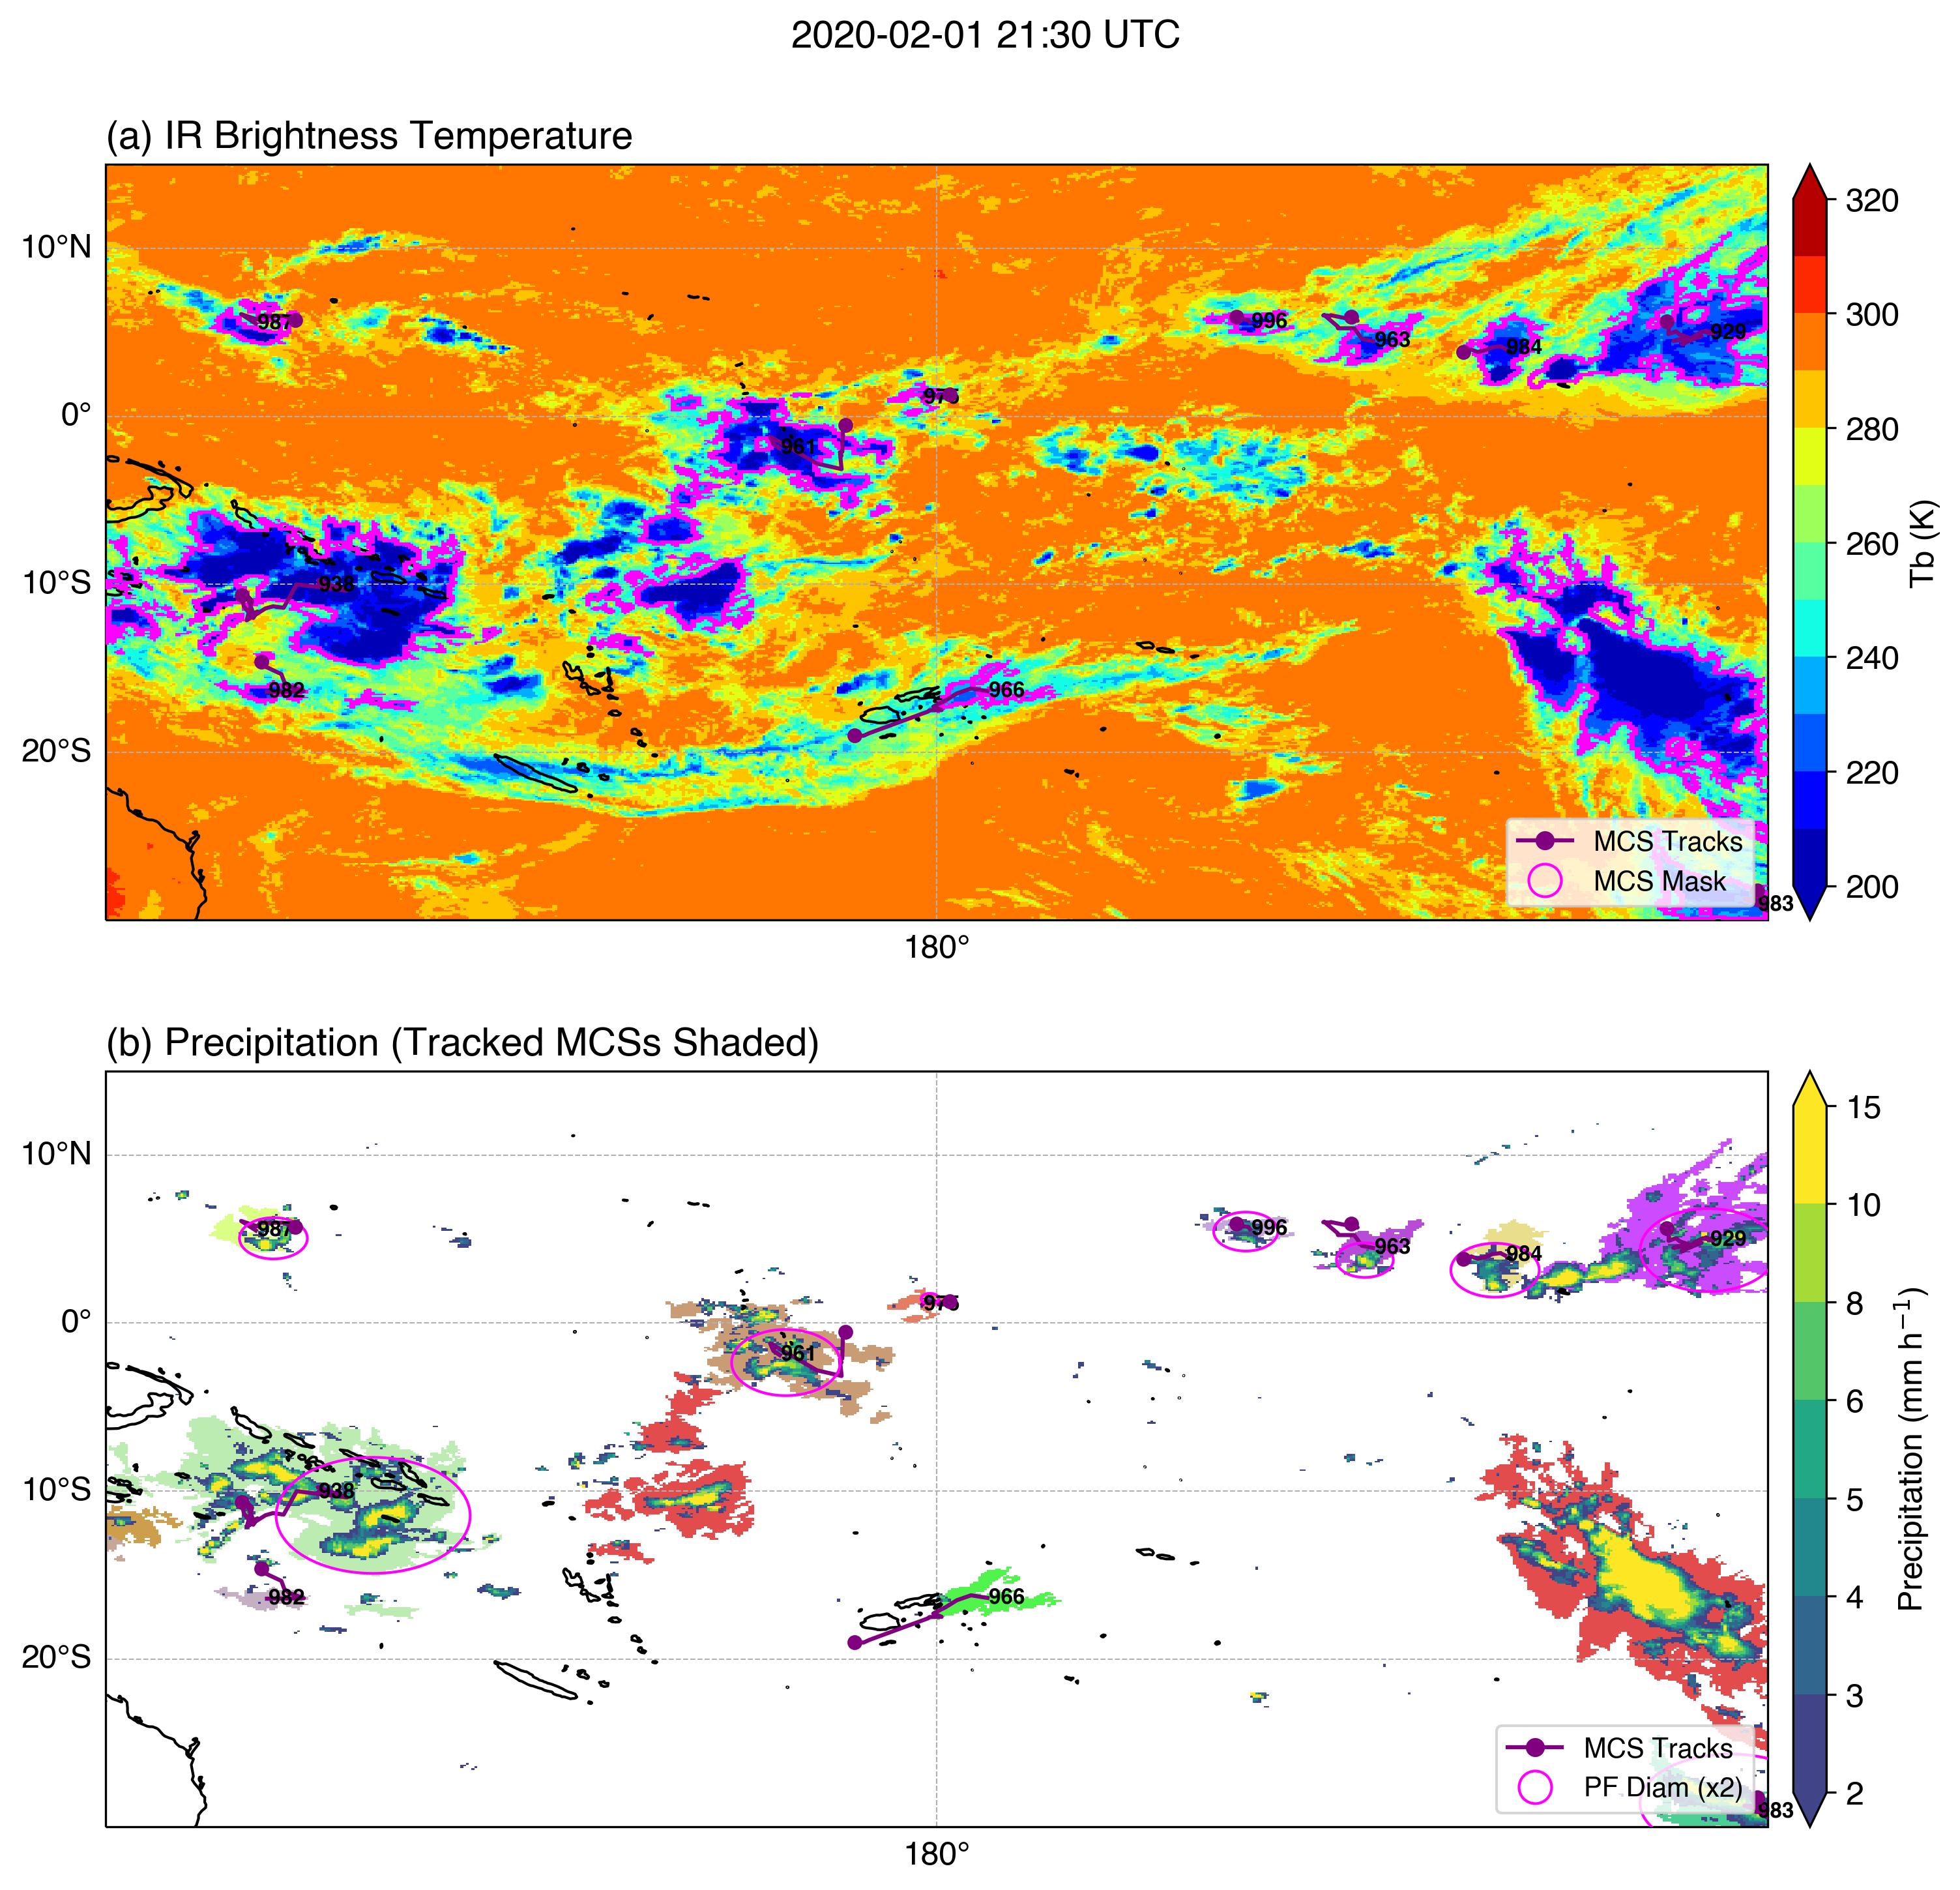

In [8]:
# for ifile in range(len(datafiles)):
for ifile in range(20, 22):
    print(datafiles[ifile])
    result = work_for_time_loop(
        datafiles[ifile], track_dict, map_info, figdir,
    )